In [40]:
import numpy  as np
import healpy as hp
import argparse
import time

from skylab.priors        import SpatialPrior
from config_GW            import config
from scipy.optimize       import curve_fit
from skylab.ps_injector   import PointSourceInjector
from scipy.stats          import chi2

import matplotlib as mpl
import matplotlib.pyplot as plt
#import csky as cy

In [ ]:
""" Original code, from Raamis
######################### CONFIGURE ARGUEMENTS #############################
p = argparse.ArgumentParser(description="Calculates Sensitivity and Discovery"
                            " Potential Fluxes for Background Gravitational wave/Neutrino Coincidence study",
                            formatter_class=argparse.RawTextHelpFormatter)
p.add_argument("--ntrials", default=1000, type=int,
                help="Number of trials (default=1000")
p.add_argument("--pid", default=0, type=int,
                help="Process ID to save unique numpy array after running (Default=0)")
p.add_argument("--gw", default=151226, type=int,
                help="Date of GW event (yr-m-d) (default=151226)")
p.add_argument('--tw', default=3., type=float,
                help='Log10(time_window) to perform search in (default=3 which corresponds to 10^3 seconds)')
args = p.parse_args()
###########################################################################

###################### CONFIGURE LLH  ########################
seasons = ['GFU_v002p05','IC86, 2011-2018']
erange  = [0,10]
index = 2.
GW_time_dict = dict({150914:57279.41024306,151226:57382.152001999784,
                     151012:57307.4130028,170104:57757.42498380,
                     170608:57912.08421863,170729:57963.78922801,
                     170809:57974.35303009,170814:57979.43800382,
                     170817:57982.52852350,170818:57983.10079977,
                     170823:57988.55137153,})
GW_time = GW_time_dict[args.gw]
time_window = 10**args.tw/2/86400 #500 seconds in days
time_mask = [time_window,GW_time]

# For 2 week analysis
#time_window = 7.05 #half of 14+0.1 day time window
#time_mask = [time_window,GW_time+6.95] #[-0.1,14] day time window

#############################################################

############# LIGO SKYMAP ###############
fitsFile = '/data/user/rhussain/fitsFiles/GW%s_skymap.fits' % args.gw

### Read map and get probabilities
probs = hp.read_map(fitsFile)
nside = hp.pixelfunc.get_nside(probs)
probs = hp.pixelfunc.ud_grade(probs,nside_out=256,power=-2)
nside = 256


### Set up spatial prior to be used in scan
spatial_prior = SpatialPrior(probs,allow_neg=True,interpolated_ts_norm=True)
##########################################

llh = config(seasons,ncpu=7, days=5,timescramble=True,
             time_mask=time_mask,poisson=True)

### Set range of for loop so that multiple jobs 
### on the cluster will still all have unique 
### seedse
ntrials = args.ntrials
stop = ntrials * (args.pid+1)
start = stop-ntrials

tsList = []
for i in range(start,stop):
    val = llh.scan(0.0,0.0, scramble = True, seed = i,spatial_prior=spatial_prior,
                    time_mask = time_mask, pixel_scan=[nside,3.0])
    try:
        tsList.append(val['TS_spatial_prior_0'].max())
    except ValueError:
        tsList.append(-np.inf)
#np.save('/home/rhussain/icecube/dump/gw%s/bkgTrials/maxTS_%s.npy' % (args.gw,args.pid), tsList)"""

In [35]:
seasons = ['GFU_v002p05','IC86, 2011-2018']
erange  = [0,10]
index = 2.
GW_time_dict = dict({150914:57279.41024306,151226:57382.152001999784,
                     151012:57307.4130028,170104:57757.42498380,
                     170608:57912.08421863,170729:57963.78922801,
                     170809:57974.35303009,170814:57979.43800382,
                     170817:57982.52852350,170818:57983.10079977,
                     170823:57988.55137153,})

#parser not working for me?
gw=151226
pid=0
tw=3. #Log10(time_window) to perform search in (default=3 for 10^3 seconds)

GW_time = GW_time_dict[gw]
time_window = 10**tw/2/86400 #500 seconds in days
time_mask = [time_window,GW_time]

############# LIGO SKYMAP ###############
fitsFile = '/data/user/rhussain/fitsFiles/GW%s_skymap.fits' % gw

### Read map and get probabilities
probs = hp.read_map(fitsFile)
nside = hp.pixelfunc.get_nside(probs)
probs = hp.pixelfunc.ud_grade(probs,nside_out=256,power=-2)
nside = 256

NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [36]:
"""Skylab parts"""
### Set up spatial prior to be used in scan
spatial_prior = SpatialPrior(probs,allow_neg=True,interpolated_ts_norm=True)

llh = config(seasons,ncpu=7, days=5,timescramble=True,
             time_mask=time_mask,poisson=True)

In [54]:
ntrials=100
mod=5
stop = ntrials * (pid+1)
start = stop-ntrials

tsList = []
for i in range(start,stop):
    val = llh.scan(0.0,0.0, scramble = True, seed = i,spatial_prior=spatial_prior,
                    time_mask = time_mask, pixel_scan=[nside,3.0])
    try:
        tsList.append(val['TS_spatial_prior_0'].max())
    except ValueError:
        tsList.append(-np.inf)
    if i%mod==0: print('%i / %i trials done.'%(i, ntrials))
print('Done.')

0 / 100
5 / 100
10 / 100
15 / 100
20 / 100
25 / 100
30 / 100
35 / 100
40 / 100
45 / 100
50 / 100
55 / 100
60 / 100
65 / 100
70 / 100
75 / 100
80 / 100
85 / 100
90 / 100
95 / 100
Done.


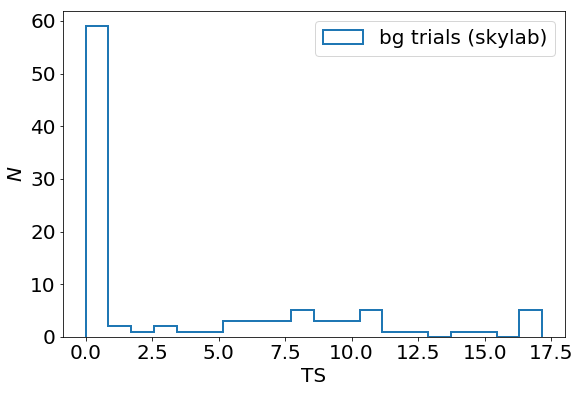

In [56]:
ts=[]
for i in range(0,len(tsList)):
    if tsList[i]<0: ts.append(0.)
    else: ts.append(tsList[i])
fig, ax = plt.subplots(figsize=(9,6))
mpl.rcParams['font.size'] = 20
ax.hist(ts, bins=20,histtype='step', lw=2., color='C0', label='bg trials (skylab)')

#ax.semilogy()
ax.set_xlabel(r'TS')
ax.set_ylabel(r'$N$')
ax.legend()
plt.show()

In [ ]:
"""Csky parts"""
ana_dir = cy.utils.ensure_dir('/home/jthwaites/csky_cache')
ana = cy.get_analysis(cy.selections.repo, 'version-002-p05', #use p6, check p5 for GW
                      cy.selections.GFUDataSpecs.GFU_IC86, dir=ana_dir)

conf = {'extended': True, #use extended LLH due to low time window
        'space': "ps",
        'time': "transient",
        'sig': 'transient',
        'ana':ana,
        'mp_cpus': 3
        }
cy.CONF.update(conf)